In [1]:
from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense

LIF?


Init signature: LIF(*args, **kwargs)
Docstring:     
Leaky-Integrate-and-Fire (LIF) neural Process.

LIF dynamics abstracts to:
u[t] = u[t-1] * (1-du) + a_in         # neuron current
v[t] = v[t-1] * (1-dv) + u[t] + bias  # neuron voltage
s_out = v[t] > vth                    # spike if threshold is exceeded
v[t] = 0                              # reset at spike

Parameters
----------
shape : tuple(int)
    Number and topology of LIF neurons.
u : float, list, numpy.ndarray, optional
    Initial value of the neurons' current.
v : float, list, numpy.ndarray, optional
    Initial value of the neurons' voltage (membrane potential).
du : float, optional
    Inverse of decay time-constant for current decay. Currently, only a
    single decay can be set for the entire population of neurons.
dv : float, optional
    Inverse of decay time-constant for voltage decay. Currently, only a
    single decay can be set for the entire population of neurons.
bias_mant : float, list, numpy.ndarray, optiona

In [2]:
import numpy as np

#processes (leaky integrate and fire extends the generic AbstractLIF, which is an AbstractProcess)
lif1 = LIF(shape=(3, ),                         # Number and topological layout of units in the process
           vth=10.,                             # Membrane threshold
           dv=0.1,                              # Inverse membrane time-constant
           du=0.1,                              # Inverse synaptic time-constant
           bias_mant=(1.1, 1.2, 1.3),           # Bias added to the membrane voltage in every timestep (for each unit)
           name="lif1")

dense = Dense(weights=np.random.rand(2, 3),     # Initial value of the weights, chosen randomly
              name='dense')

lif2 = LIF(shape=(2, ),                         
           vth=10.,                             
           dv=0.1,                              
           du=0.1,                             
           bias_mant=0.,                        
           name='lif2')

In [3]:
for proc in [lif1, lif2, dense]:
    for port in proc.in_ports:
        print(f'Proc: {proc.name:<5}  Name: {port.name:<5}  Size: {port.size}')
    for port in proc.out_ports:
        print(f'Proc: {proc.name:<5}  Name: {port.name:<5}  Size: {port.size}')

Proc: lif1   Name: a_in   Size: 3
Proc: lif1   Name: s_out  Size: 3
Proc: lif2   Name: a_in   Size: 2
Proc: lif2   Name: s_out  Size: 2
Proc: dense  Name: s_in   Size: 3
Proc: dense  Name: a_out  Size: 2


In [3]:
#LIF layers have analog input spike output and dense layers have spike inputs and analog outputs
lif1.s_out.connect(dense.s_in)
dense.a_out.connect(lif2.a_in)

In [5]:
for var in lif1.vars:
    print(f'Var: {var.name:<9}  Shape: {var.shape}  Init: {var.init}')
    
dense.weights.get()

Var: bias_exp   Shape: (3,)  Init: 0
Var: bias_mant  Shape: (3,)  Init: (1.1, 1.2, 1.3)
Var: du         Shape: (1,)  Init: 0.1
Var: dv         Shape: (1,)  Init: 0.1
Var: u          Shape: (3,)  Init: 0
Var: v          Shape: (3,)  Init: 0
Var: vth        Shape: (1,)  Init: 10.0


array([[0.93442623, 0.87546681, 0.13124305],
       [0.00621974, 0.78557065, 0.76997027]])

In [5]:
from lava.proc.monitor.process import Monitor

monitor_lif1 = Monitor()
monitor_lif2 = Monitor()

num_steps = 100

#monitors to probe the voltages of the LIF layers over time
monitor_lif1.probe(lif1.v, num_steps)
monitor_lif2.probe(lif2.v, num_steps)

In [6]:
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg

run_condition = RunSteps(num_steps=100)
run_cfg = Loihi1SimCfg(select_tag="floating_pt")

lif2.run(condition=run_condition, run_cfg=run_cfg)

data_lif1 = monitor_lif1.get_data()
data_lif2 = monitor_lif2.get_data()

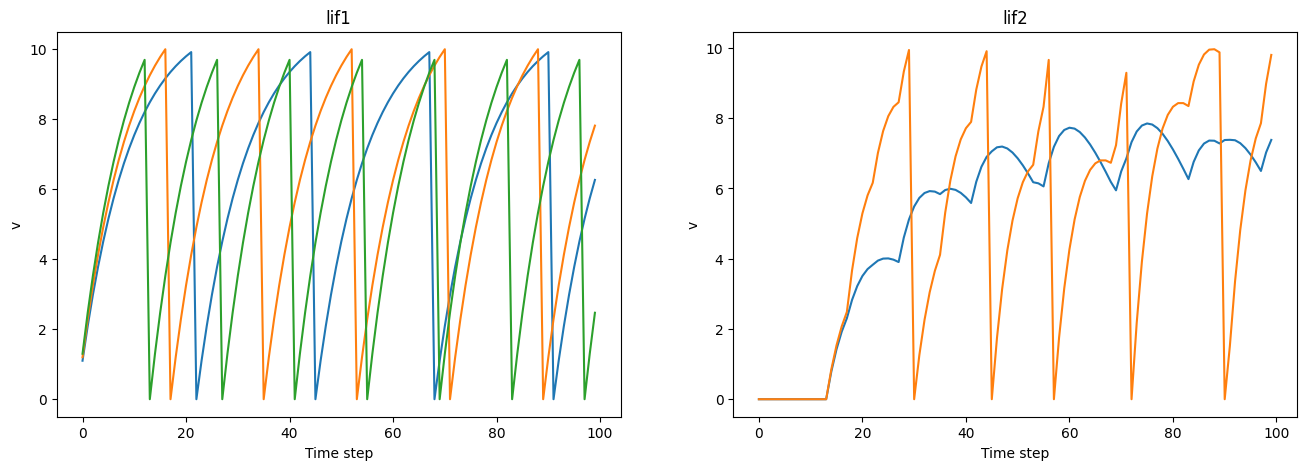

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt

# Create a subplot for each monitor
fig = plt.figure(figsize=(16, 5))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

# Plot the recorded data
monitor_lif1.plot(ax0, lif1.v)
monitor_lif2.plot(ax1, lif2.v)

In [8]:
lif2.stop()

In [ ]:
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import OutPort

class SpikeGenerator(AbstractProcess):
     """Spike generator process provides spikes to subsequent Processes.

    Parameters
    ----------
    shape: tuple
        defines the dimensionality of the generated spikes per timestep
    spike_prob: int
        spike probability in percent
    """
     def __init__(self, shape: tuple, spike_prob: int) -> None:        
        super().__init__()
        self.spike_prob = Var(shape=(1, ), init=spike_prob) #tensor is a vector with one element with a value of spike_prob
        self.s_out = OutPort(shape=shape)


In [ ]:
from lava.magma.core.model.py.model import PyLoihiProcessModel
from lava.magma.core.resources import CPU
from lava.magma.core.decorator import implements, requires
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.model.py.ports import PyOutPort

@implements(proc=SpikeGenerator, protocol=LoihiProtocol)
@requires(CPU) #runs on CPU
class PySpikeGeneratorModel(PyLoihiProcessModel):
    """Spike Generator process model."""
    spike_prob: int = LavaPyType(int, int)
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)

    # Generate and send random spike data (set probabilities for generating either 0 or 1)
    def run_spk(self) -> None:
        spike_data = np.random.choice([0, 1], p=[1 - self.spike_prob/100, self.spike_prob/100], size=self.s_out.shape[0])
        
        self.s_out.send(spike_data)

In [ ]:
lif1 = LIF(shape=(3, ),                         # Number of units in this process
           vth=10.,                             # Membrane threshold
           dv=0.1,                              # Inverse membrane time-constant
           du=0.1,                              # Inverse synaptic time-constant
           bias_mant=0.,                        # Bias added to the membrane voltage in every timestep
           name="lif1")

dense = Dense(weights=np.random.rand(2, 3),     # Initial value of the weights, chosen randomly
              name='dense')

lif2 = LIF(shape=(2, ),                         
           vth=10.,                             
           dv=0.1,                              
           du=0.1,                             
           bias_mant=0.,                       
           name='lif2')

lif1.s_out.connect(dense.s_in)
dense.a_out.connect(lif2.a_in)

monitor_lif1 = Monitor()
monitor_lif2 = Monitor()

monitor_lif1.probe(lif1.v, num_steps)
monitor_lif2.probe(lif2.v, num_steps)

In [ ]:
spike_gen = SpikeGenerator(shape = (lif1.a_in.shape[0], ), spike_prob=77)

# Instantiate Dense
dense_input = Dense(weights=np.eye(lif1.a_in.shape[0])) # one-to-one connectivity

# Connect spike_gen to dense_input
spike_gen.s_out.connect(dense_input.s_in)

# Connect dense_input to LIF1 population
dense_input.a_out.connect(lif1.a_in)

lif2.run(condition=run_condition, run_cfg=run_cfg)

In [ ]:
fig = plt.figure(figsize=(16, 5))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

# Plot the recorded data
monitor_lif1.plot(ax0, lif1.v)
monitor_lif2.plot(ax1, lif2.v)

In [4]:
from lava.magma.core.run_configs import Loihi1SimCfg

ex = lif1.compile(run_cfg=Loihi1SimCfg())


In [6]:
import tempfile
from lava.utils.serialization import save, load

with tempfile.TemporaryDirectory() as tmpdirname:
    save(processes=[lif1, lif2, dense],
         filename=tmpdirname + "test",
         executable=ex)

    procs, loaded_ex = load(tmpdirname + "test.pickle")
print(procs)
input_lif = procs[0]
output_lif = procs[1]


[<lava.proc.lif.process.LIF object at 0x103b86140>, <lava.proc.lif.process.LIF object at 0x13850a9b0>, <lava.proc.dense.process.Dense object at 0x13850b9d0>]
